In [1]:
import os
from torch import optim
from ignite.handlers import FastaiLRFinder
from ignite.engine import Events, create_supervised_trainer
from mevgs.train import (
    CONFIGS,
    UtilsTraining,
    identity_loss,
    setup_data,
    setup_model,
)

In [2]:
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = "5"

In [3]:
config = CONFIGS["17"]

In [4]:

device = config["device"]
model = setup_model(**config["model"])
model.to(device=device)

/home/doneata/miniconda3/envs/mattnet/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/doneata/miniconda3/envs/mattnet/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


Using pretrained AlexNet


MattNet(
  (audio_enc): AudioEncoderTransformer(
    (layer): TransformerEncoderLayer(
      (self_attn): MultiheadAttention(
        (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
      )
      (linear1): Linear(in_features=768, out_features=2048, bias=True)
      (dropout): Dropout(p=0.1, inplace=False)
      (linear2): Linear(in_features=2048, out_features=768, bias=True)
      (norm1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (norm2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout1): Dropout(p=0.1, inplace=False)
      (dropout2): Dropout(p=0.1, inplace=False)
    )
    (encoder): TransformerEncoder(
      (layers): ModuleList(
        (0): TransformerEncoderLayer(
          (self_attn): MultiheadAttention(
            (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
          )
          (linear1): Linear(in_features=768, out_features=2048, bias=True)
      

In [5]:
optimizer = optim.Adam(model.parameters(), **config["optimizer"])

In [6]:
trainer = create_supervised_trainer(
    model,
    optimizer,
    prepare_batch=UtilsTraining.prepare_batch_fn,
    model_fn=UtilsTraining.model_fn,
    loss_fn=identity_loss,
    device=device,
)

In [7]:
def print_metrics(engine, tag):
    print("{:s} · {:4d} / {:4d} · loss: {:.3f}".format(
            tag,
            engine.state.epoch,
            engine.state.iteration,
            engine.state.output,
        )
    )

trainer.add_event_handler(
    Events.ITERATION_COMPLETED(every=1),
    print_metrics,
    tag="train",
)


In [8]:
config["data"]["batch_size"] = 48
dataloader_train, _ = setup_data(**config["data"])

2024-07-18 22:43:07,028 ignite.distributed.auto.auto_dataloader INFO: Use data loader kwargs for dataset '<mevgs.data.PairedME': 
	{'num_workers': 16, 'batch_size': 48, 'collate_fn': <function collate_nested at 0x7ff6baaf6950>, 'shuffle': True, 'pin_memory': True}
2024-07-18 22:43:07,031 ignite.distributed.auto.auto_dataloader INFO: Use data loader kwargs for dataset '<mevgs.data.PairedME': 
	{'num_workers': 16, 'batch_size': 48, 'collate_fn': <function collate_nested at 0x7ff6baaf6950>, 'pin_memory': True}


In [9]:
lr_finder = FastaiLRFinder()
to_save = {"optimizer": optimizer}

with lr_finder.attach(trainer, to_save=to_save, num_iter=256, start_lr=1e-8, end_lr=1e-2) as trainer_with_lr_finder:
    trainer_with_lr_finder.run(dataloader_train)


train ·    1 /    1 · loss: 6.472
train ·    1 /    2 · loss: 6.677
train ·    1 /    3 · loss: 5.802
train ·    1 /    4 · loss: 4.651
train ·    1 /    5 · loss: 4.837
train ·    1 /    6 · loss: 4.609
train ·    1 /    7 · loss: 4.336
train ·    1 /    8 · loss: 5.368
train ·    1 /    9 · loss: 5.063
train ·    1 /   10 · loss: 5.526
train ·    1 /   11 · loss: 4.745
train ·    1 /   12 · loss: 4.602
train ·    1 /   13 · loss: 5.560
train ·    1 /   14 · loss: 5.155
train ·    1 /   15 · loss: 5.235
train ·    1 /   16 · loss: 6.722
train ·    1 /   17 · loss: 5.153
train ·    1 /   18 · loss: 4.681
train ·    1 /   19 · loss: 5.000
train ·    1 /   20 · loss: 6.556
train ·    1 /   21 · loss: 5.153
train ·    1 /   22 · loss: 5.846
train ·    1 /   23 · loss: 5.982
train ·    1 /   24 · loss: 4.662
train ·    1 /   25 · loss: 4.859
train ·    1 /   26 · loss: 5.299
train ·    1 /   27 · loss: 5.947
train ·    1 /   28 · loss: 4.911
train ·    1 /   29 · loss: 6.590
train ·    1 /

In [10]:
lr_finder.get_results()

{'lr': [1.055449600878603e-08,
  1.1139738599948023e-08,
  1.175743265920711e-08,
  1.2409377607517196e-08,
  1.3097472643005899e-08,
  1.3823722273578995e-08,
  1.4590242156305607e-08,
  1.539926526059492e-08,
  1.6253148373118646e-08,
  1.715437896342879e-08,
  1.810558243027122e-08,
  1.9109529749704407e-08,
  2.0169145547303305e-08,
  2.1287516617963726e-08,
  2.2467900918126445e-08,
  2.371373705661655e-08,
  2.502865431174608e-08,
  2.6416483203860923e-08,
  2.7881266654131334e-08,
  2.942727176209282e-08,
  3.105900223624705e-08,
  3.2781211513934586e-08,
  3.459891660869933e-08,
  3.651741272548377e-08,
  3.854228868623106e-08,
  4.067944321083047e-08,
  4.293510210083482e-08,
  4.5315836376008177e-08,
  4.782858141653791e-08,
  5.0480657166674703e-08,
  5.327978945865641e-08,
  5.623413251903491e-08,
  5.9352292722969866e-08,
  6.264335366568855e-08,
  6.611690262414816e-08,
  6.978305848598663e-08,
  7.36525012271228e-08,
  7.773650302387758e-08,
  8.20469610902499e-08,
  8.6

/home/doneata/miniconda3/envs/mattnet/lib/python3.10/site-packages/ignite/handlers/lr_finder.py:293: UserWarning: skip_start is larger than the suggested LR found and it will not be visible on the plot. Please, make the value smaller.
  warnings.warn(


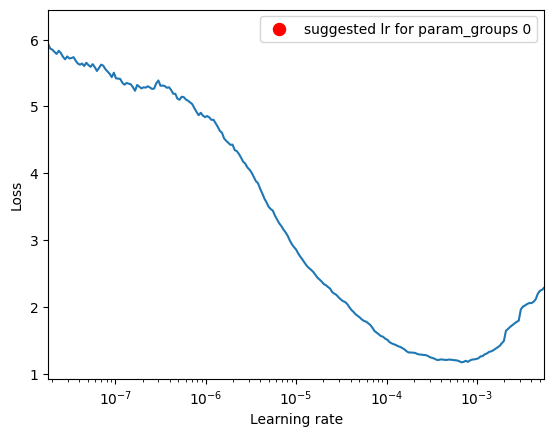

<Axes: xlabel='Learning rate', ylabel='Loss'>

In [11]:

lr_finder.plot()

In [12]:
lr_finder.lr_suggestion()

1.3823722273578995e-08